### Import Packages

In [342]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import ast


### Connect to Azure

In [307]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Load Image Paths and Labels

In [383]:
#get filepaths
import pandas as pd
df = pd.read_csv("/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/2_Semester/ML/Assignments/machine_learning/ML_Final_Project/preprocessed.csv")

filenames = df["filename"]
# convert each string in the DataFrame to a list
df['Labels'] = df['Labels'].apply(ast.literal_eval)

# convert each list in the DataFrame to a numpy array
df['Labels'] = df['Labels'].apply(np.array)

# store all the arrays in a list
labels = df['Labels'].tolist()

### Set Variables

In [384]:
image_size=224
channels=3

batch_size = 224 # Big enough to measure an F1-score
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
shuffle_buffer_size = 1024 # Shuffle the training data by a chunck of 1024 observations

### Functions to create data (input for models)

In [385]:
def load_image(path):
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    return io.BytesIO(blob_data)

def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path.numpy().decode('utf-8'))
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized


def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""
    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly for grayscale
    image_normalized.set_shape([image_size, image_size, channels])
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=1024)
        
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


### Create the dataset

In [386]:
train_ds = create_dataset(filenames, labels)

### Print the dataset

In [387]:
for images, labels in train_ds.take(1):  # Here, take(1) takes the first batch
    print("Images:", images.numpy())  # Convert tensor to numpy array and print
    print("Labels:", labels.numpy())  # Convert tensor to numpy array and print


2024-05-09 09:39:46.463841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-09 09:39:46.464344: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


Images: [[[[0.6325905  0.64827675 0.6486219 ]
   [0.63329834 0.6469888  0.6627451 ]
   [0.63350844 0.64527315 0.664881  ]
   ...
   [0.47829133 0.47436976 0.4586835 ]
   [0.46652663 0.46652663 0.462535  ]
   [0.47436976 0.47436976 0.47037813]]

  [[0.5887055  0.60219336 0.61835486]
   [0.620028   0.6317927  0.66708684]
   [0.61939776 0.63116246 0.6664566 ]
   ...
   [0.47286415 0.46894258 0.4532563 ]
   [0.46687675 0.4707983  0.44912466]
   [0.4687325  0.47265407 0.4509804 ]]

  [[0.6123249  0.6240896  0.6515406 ]
   [0.62352943 0.63529414 0.6627451 ]
   [0.62352943 0.63529414 0.6627451 ]
   ...
   [0.4802171  0.4802171  0.4802171 ]
   [0.47058824 0.47058824 0.47058824]
   [0.46666667 0.46666667 0.46666667]]

  ...

  [[0.69299716 0.71652657 0.71652657]
   [0.69411767 0.7176471  0.7176471 ]
   [0.6915966  0.7151261  0.7151261 ]
   ...
   [0.6039216  0.6392157  0.627451  ]
   [0.58861804 0.62391216 0.61214745]
   [0.5921569  0.627451   0.6156863 ]]

  [[0.69299716 0.71652657 0.71652657]

In [394]:
#check dataset shape
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (50, 224, 224, 3)
Shape of labels array: (50, 8)


2024-05-09 09:41:48.072837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-09 09:41:48.073213: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]


### Plot one image from the dataset

2024-05-09 09:39:55.084128: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]
2024-05-09 09:39:55.084536: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50,8]
	 [[{{node Placeholder/_1}}]]


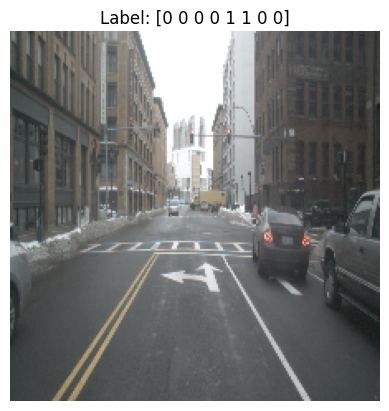

In [389]:
def plot_first_image_from_dataset(dataset, index):
    # Take one batch from the dataset
    for images, labels in dataset.take(index):
        # Assuming the image tensor is in the shape [batch_size, height, width, channels]
        # and you need the first image in the batch
        first_image = images[0]  # This is a tensor

        # Check if the image needs to be squeezed (in case it's a grayscale image with a single channel)
        if first_image.shape[-1] == 1:
            first_image = tf.squeeze(first_image, axis=-1)
        
        # Convert tensor to numpy for plotting
        first_image_np = first_image.numpy()

        # Plot the image
        plt.imshow(first_image_np, cmap='gray')
        plt.title(f'Label: {labels[0].numpy()}')
        plt.axis('off')
        plt.show()

# Example usage with your train_ds dataset
plot_first_image_from_dataset(train_ds,1)

### Self Trained VGG
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf

_input = Input((224,224,1)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(8, activation="sigmoid")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)

LR = 1e-5 #why?
EPOCHS = 10 #why?


#compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##provide a model summary
vgg16_model.summary()

#fit the model
vgg16_model.fit(
    train_ds,
    epochs=EPOCHS
)

In [ ]:
#get prediction
predictions = vgg16_model.predict(train_ds)
predictions


### Plot model

In [ ]:
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
plot_model(model, 
           to_file='vgg.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           show_layer_activations=True,
           show_trainable=False,)

### Pre-trained

MobileNetV2: https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb

In [402]:
from tensorflow.keras import layers
import tensorflow_hub as hub


IMG_SIZE = 224
CHANNELS = 3
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

feature_extractor_layer.trainable = False

model_mnv2 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(8, activation='sigmoid', name='output')
])

model_mnv2.summary()

for images, labels in train_ds:
    predictions = model_mnv2.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 8)                 8200      
                                                                 
Total params: 3577928 (13.65 MB)
Trainable params: 1319944 (5.04 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
2/2 [==============================] - 1s 219ms/step
Prediction: [0.21712492 0.26363263 0.6487266  0.7814641  0.3121688  0.7571568
 0.19447498 0.16630785] Actual Label: [0 1 0 0 1 1 0 0]
Prediction: [0.11792246 0.3692654  0.6934157  0.6901063  0.36747327 0.33245176
 0.51270

Inception.v3: https://towardsdatascience.com/understanding-the-amazon-rainforest-with-multi-label-classification-vgg-19-inceptionv3-5084544fb655

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras.models import Model

def create_inception_v3_model():
    inceptionv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in inceptionv3.layers:
        layer.trainable = False

    # Adding custom layers
    x = inceptionv3.output
    x = GlobalAveragePooling2D()(x)  # Ensure this reduces all spatial dimensions
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.1)(x)
    output = Dense(8, activation="sigmoid")(x)  # Adjust the number of output units to match the number of classes

    # Creating the final model
    model = Model(inputs=inceptionv3.input, outputs=output)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

# Instantiate and compile the model
inceptionv3_model = create_inception_v3_model()

# Set up the model checkpoint
model_checkpoint = ModelCheckpoint('inceptionv3_model.h5', monitor="val_accuracy", verbose=1, save_best_only=True)

# Assuming train_ds, X_test, y_test are properly defined
inceptionv3_model.fit(train_ds, epochs=10, callbacks=[model_checkpoint])


In [ ]:
#predict
for images, labels in train_ds:
    predictions = inceptionv3_model.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

VGG16: https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

In [ ]:
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(8, activation='sigmoid')


model_vgg = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


from keras.callbacks import EarlyStopping

model_vgg.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#model_vgg.fit(train_ds, epochs=10, batch_size=32, callbacks=[es])

In [ ]:
for images, labels in train_ds:
    predictions = model_vgg.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

ResNet50: https://datagen.tech/guides/computer-vision/resnet-50/

In [ ]:
from tensorflow.keras.models import Sequential
resnet_model = Sequential()

rn50_base = keras.applications.ResNet50(
    weights = "imagenet",
    input_shape=(224,224,3)
    )

for each_layer in rn50_base.layers:

        each_layer.trainable=False

resnet_model.add(rn50_base)

resnet_model.add(Flatten())

resnet_model.add(Dense(512, activation='relu'))

resnet_model.add(Dense(8, activation='sigmoid'))

resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

resnet_model.fit(train_ds, epochs=10)



In [ ]:
for images, labels in train_ds:
    predictions = model_vgg.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

### Pre Trained Weights

https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104

In [2]:
class RockPaperScissorsVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 3
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, classes=self.classes, include_top=False)

        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train_vgg16(train_images, train_labels) -> Model:
        vgg16 = RockPaperScissorsVgg16(INPUT_WIDTH, INPUT_HEIGHT)
        model = vgg16.model
        model.summary()

        train_generator, validation_generator = get_generators(train_images, train_labels)

        model.fit(
            train_generator,
            steps_per_epoch=40,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=10,
            callbacks=[StopByAccuracyCallback()]
        )

        return model